In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/vehicles.csv')
data = data.drop(columns=['id', 'VIN']) # Identifiers will not give much information for modeling
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

for col in categorical_columns:
    data[col] = data[col].str.lower().str.strip()

data_og = data.copy()

# Eliminating NaNs

              NaN Count  NaN Percentage
region                0        0.000000
price                 0        0.000000
year               1205        0.282281
manufacturer      17646        4.133714
model              5277        1.236179
condition        174104       40.785232
cylinders        177678       41.622470
fuel               3013        0.705819
odometer           4400        1.030735
title_status       8242        1.930753
transmission       2556        0.598763
drive            130567       30.586347
size             306361       71.767476
type              92858       21.752717
paint_color      130203       30.501078
state                 0        0.000000


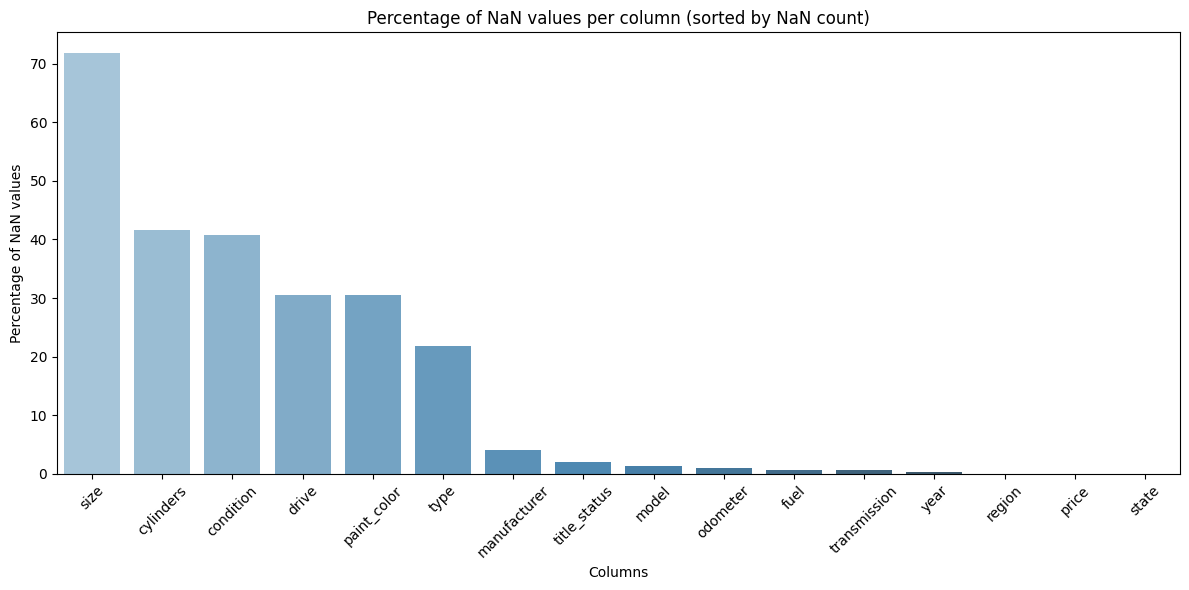

In [4]:
nan_per_column = data_og.isna().sum()
total_rows = len(data_og)

nan_percentage = (nan_per_column / total_rows) * 100

nan_df = pd.DataFrame({
    'NaN Count': nan_per_column,
    'NaN Percentage': nan_percentage
})

nan_df_sorted = nan_df.sort_values(by='NaN Count', ascending=False)
print(nan_df)

plt.figure(figsize=(12, 6))
sns.barplot(x=nan_df_sorted.index, y=nan_df_sorted['NaN Percentage'], hue=nan_df_sorted.index, legend=False, palette="Blues_d")
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN values')
plt.title('Percentage of NaN values per column (sorted by NaN count)')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

### Size

In [6]:
data=data.drop(columns='size') # too many NaNs
categorical_columns.remove('size')

### Cylinders

In [8]:
# Calculate the most common cylinders value for each model and manufacturer
most_common_cylinders_by_model = data.groupby('model')['cylinders'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
most_common_cylinders_by_manufacturer = data.groupby('manufacturer')['cylinders'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def impute_cylinders_by_model_and_manufacturer(row):
    if pd.isna(row['cylinders']):  
        model = row['model']
        manufacturer = row['manufacturer']
        

        if model in most_common_cylinders_by_model:
            common_cylinders_model = most_common_cylinders_by_model[model]
            if not pd.isna(common_cylinders_model):
                return common_cylinders_model
        
        if manufacturer in most_common_cylinders_by_manufacturer:
            common_cylinders_manufacturer = most_common_cylinders_by_manufacturer[manufacturer]
            if not pd.isna(common_cylinders_manufacturer): 
                return common_cylinders_manufacturer
        return np.nan
        
    else:
        return row['cylinders']  

data['cylinders_imputed'] = data.apply(impute_cylinders_by_model_and_manufacturer, axis=1)

nan_count = data['cylinders'].isna().sum()
print(f'Total NaN values in cylinders: {nan_count}')
nan_count_imputed = data['cylinders_imputed'].isna().sum()
print(f'Total NaN values in cylinders_imputed: {nan_count_imputed}')

print(f'Fraction of NaN values present in cylinders: {nan_count/len(data)*100}%')
print(f'Fraction of NaN values present in cylinders_imputed: {nan_count_imputed/len(data)*100}%')

Total NaN values in cylinders: 177678
Total NaN values in cylinders_imputed: 3538
Fraction of NaN values present in cylinders: 41.6224700149925%
Fraction of NaN values present in cylinders_imputed: 0.828804347826087%


### Condition

In [10]:
condition_order = {
    'new': 5,
    'like new': 4,
    'excellent': 3,
    'good': 2,
    'fair': 1,
    'salvage': 0
}

data['condition_ranked'] = data['condition'].map(condition_order)

df_filtered = data.dropna(subset=['odometer', 'year'])
df_filtered = df_filtered.dropna(subset=['condition_ranked'])

X = df_filtered[['odometer', 'year']]
y = df_filtered['condition_ranked']

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X, y)

missing_mask = data['condition'].isna() & data['odometer'].notna() & data['year'].notna()

data.loc[missing_mask, 'condition_ranked'] = log_model.predict(data.loc[missing_mask, ['odometer', 'year']])

reverse_condition_order = {v: k for k, v in condition_order.items()}
data['condition_imputed'] = data['condition_ranked'].map(reverse_condition_order)

In [11]:
nan_count = data['condition'].isna().sum()
print(f'Total NaN values in condition: {nan_count}')
nan_count_imputed = data['condition_imputed'].isna().sum()
print(f'Total NaN values in condition_imputed: {nan_count_imputed}')

print(f'Fraction of NaN values present in condition: {nan_count/len(data)*100}%')
print(f'Fraction of NaN values present in condition_imputed: {nan_count_imputed/len(data)*100}%')

Total NaN values in condition: 174104
Total NaN values in condition_imputed: 3611
Fraction of NaN values present in condition: 40.78523238380809%
Fraction of NaN values present in condition_imputed: 0.845905172413793%


### Drive

In [13]:
print("Before Imputation - Missing 'drive' values:", data['drive'].isna().sum())

most_common_drive_by_model = data.groupby('model')['drive'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def impute_drive_by_model(row):
    if pd.isna(row['drive']):
        return most_common_drive_by_model.get(row['model'], row['drive'])
    else:
        return row['drive']

data['drive_imputed'] = data.apply(impute_drive_by_model, axis=1)

print("After Imputation via model - Missing 'drive' values:", data['drive_imputed'].isna().sum())

most_common_drive_by_type = data.groupby('type')['drive'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def impute_drive_by_type(row):
    if pd.isna(row['drive_imputed']): 
        return most_common_drive_by_type.get(row['type'], np.nan)
    else:
        return row['drive_imputed']

data['drive_imputed'] = data.apply(impute_drive_by_type, axis=1)

print("After Imputation via 'type' - Missing 'drive' values:", data['drive_imputed'].isna().sum())

Before Imputation - Missing 'drive' values: 130567
After Imputation via model - Missing 'drive' values: 24984
After Imputation via 'type' - Missing 'drive' values: 8685


In [14]:
nan_count = data['drive'].isna().sum()
print(f'Total NaN values in drive: {nan_count}')
nan_count_imputed = data['drive_imputed'].isna().sum()
print(f'Total NaN values in drive_imputed: {nan_count_imputed}')

print(f'Fraction of NaN values present in drive: {nan_count/len(data)*100}%')
print(f'Fraction of NaN values present in drive_imputed: {nan_count_imputed/len(data)*100}%')

Total NaN values in drive: 130567
Total NaN values in drive_imputed: 8685
Fraction of NaN values present in drive: 30.586347451274364%
Fraction of NaN values present in drive_imputed: 2.0345296101949026%


### Type

In [16]:
print("Before Imputation via 'model' - Missing 'type' values:", data['type'].isna().sum())

most_common_type_by_model = data.groupby('model')['type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def impute_type_by_model(row):
    if pd.isna(row['type']):  
        return most_common_type_by_model.get(row['model'], np.nan)  
    else:
        return row['type']

data['type_imputed'] = data.apply(impute_type_by_model, axis=1)

print("After Imputation via 'model'  - Missing 'type' values:", data['type_imputed'].isna().sum())

most_common_type_by_group = data.groupby(['drive', 'fuel', 'cylinders'])['type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

def impute_type_by_group(row):
    if pd.isna(row['type_imputed']):
        return most_common_type_by_group.get((row['drive'], row['fuel'], row['cylinders']), np.nan)
    else:
        return row['type_imputed']

data['type_imputed'] = data.apply(impute_type_by_group, axis=1)

print("After Imputation via 'drive', 'fuel', and 'cylinders'  - Missing 'type' values:", data['type_imputed'].isna().sum())

Before Imputation via 'model' - Missing 'type' values: 92858
After Imputation via 'model'  - Missing 'type' values: 11825
After Imputation via 'drive', 'fuel', and 'cylinders'  - Missing 'type' values: 9468


In [17]:
nan_count = data['type'].isna().sum()
print(f'Total NaN values in type: {nan_count}')
nan_count_imputed = data['type_imputed'].isna().sum()
print(f'Total NaN values in type_imputed: {nan_count_imputed}')

print(f'Fraction of NaN values present in type: {nan_count/len(data)*100}%')
print(f'Fraction of NaN values present in type_imputed: {nan_count_imputed/len(data)*100}%')

Total NaN values in type: 92858
Total NaN values in type_imputed: 9468
Fraction of NaN values present in type: 21.752717391304348%
Fraction of NaN values present in type_imputed: 2.2179535232383807%


### Paint Color
Just Remove

In [19]:
data = data.drop(columns='paint_color') # Hard to impute 

### Check distribution of missing values before and after imputation

In [21]:
data=data.drop(columns=['cylinders', 'condition', 'condition_ranked', 'drive', 'type'])

              NaN Count  NaN Percentage
size             306361       71.767476
cylinders        177678       41.622470
condition        174104       40.785232
drive            130567       30.586347
paint_color      130203       30.501078
type              92858       21.752717
manufacturer      17646        4.133714
title_status       8242        1.930753
model              5277        1.236179
odometer           4400        1.030735
fuel               3013        0.705819
transmission       2556        0.598763
year               1205        0.282281
region                0        0.000000
price                 0        0.000000
state                 0        0.000000


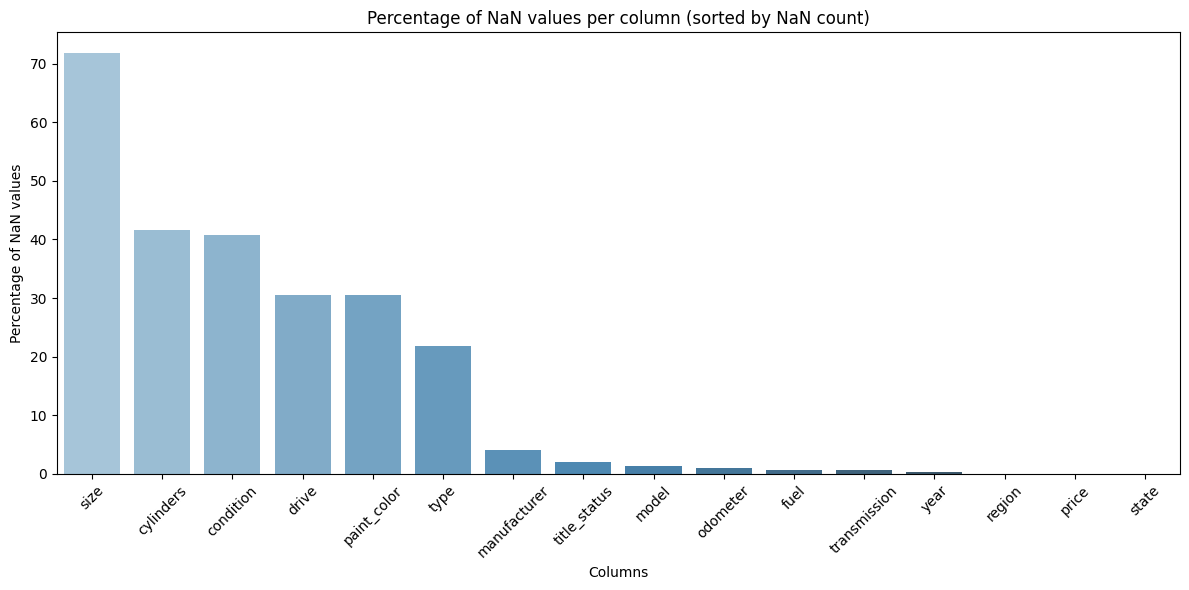

In [22]:
nan_per_column = data_og.isna().sum()
total_rows = len(data_og)

nan_percentage = (nan_per_column / total_rows) * 100

nan_df = pd.DataFrame({
    'NaN Count': nan_per_column,
    'NaN Percentage': nan_percentage
})

nan_df_sorted = nan_df.sort_values(by='NaN Count', ascending=False)
print(nan_df_sorted)

plt.figure(figsize=(12, 6))
sns.barplot(x=nan_df_sorted.index, y=nan_df_sorted['NaN Percentage'], hue=nan_df_sorted.index, legend=False, palette="Blues_d")
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN values')
plt.title('Percentage of NaN values per column (sorted by NaN count)')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

                   NaN Count  NaN Percentage
manufacturer           17646        4.133714
type_imputed            9468        2.217954
drive_imputed           8685        2.034530
title_status            8242        1.930753
model                   5277        1.236179
odometer                4400        1.030735
condition_imputed       3611        0.845905
cylinders_imputed       3538        0.828804
fuel                    3013        0.705819
transmission            2556        0.598763
year                    1205        0.282281
region                     0        0.000000
price                      0        0.000000
state                      0        0.000000


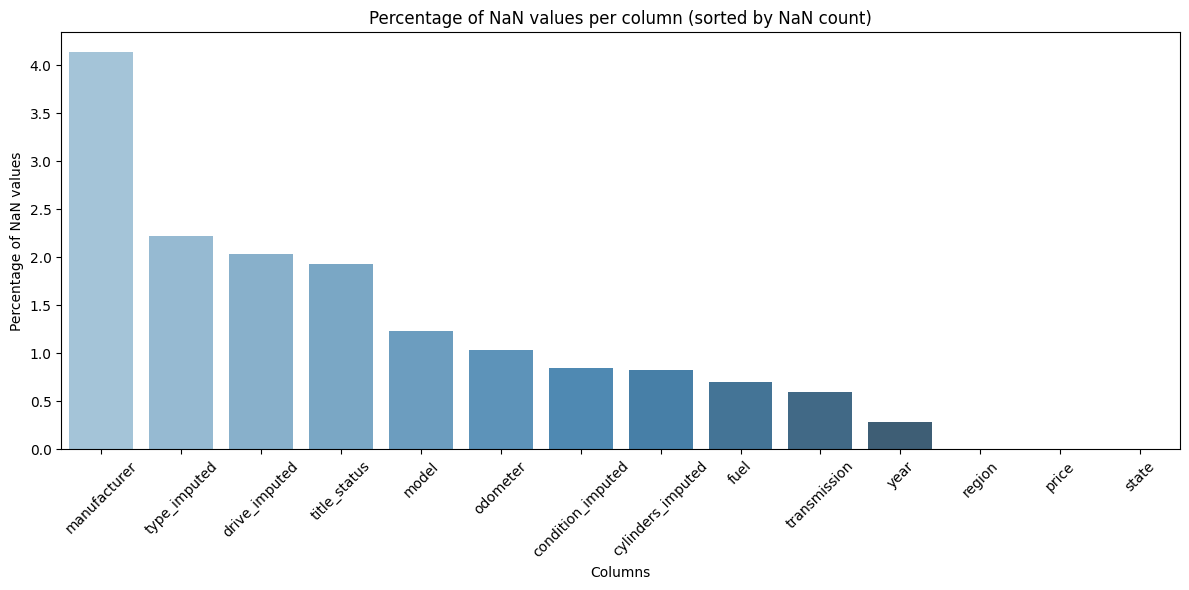

In [23]:
nan_per_column = data.isna().sum()
total_rows = len(data)

nan_percentage = (nan_per_column / total_rows) * 100

nan_df = pd.DataFrame({
    'NaN Count': nan_per_column,
    'NaN Percentage': nan_percentage
})

nan_df_sorted = nan_df.sort_values(by='NaN Count', ascending=False)
print(nan_df_sorted)

plt.figure(figsize=(12, 6))
sns.barplot(x=nan_df_sorted.index, y=nan_df_sorted['NaN Percentage'], hue=nan_df_sorted.index, legend=False, palette="Blues_d")
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN values')
plt.title('Percentage of NaN values per column (sorted by NaN count)')
plt.xticks(rotation=45)  
plt.tight_layout()  
plt.show()

In [24]:
nan_og = data_og.isna().sum().sum()
nan_data = data.isna().sum().sum()

print(f'NaNs in original dataframe: {nan_og}')
print(f'NaNs in new dataframe: {nan_data}')

print(f'{(nan_og - nan_data)/nan_og*100}% of NaNs were removed')

NaNs in original dataframe: 1054110
NaNs in new dataframe: 67641
93.58311751145516% of NaNs were removed


# Encoding Categorical Variables

### Region and State Encoding

In [27]:
with open('data/state_coords.json', 'r') as f:
    state_coords = json.load(f)

with open('data/region_coords.json', 'r') as f:
    region_coords = json.load(f)

n = 5  

first_n_items = list(state_coords.items())[:n]

for key, value in first_n_items:
    print(f'{key}: {value}')

first_n_items = list(region_coords.items())[:n]

for key, value in first_n_items:
    print(f'{key}: {value}')

az: {'lat': 34.0489, 'lon': -111.0937}
ar: {'lat': 35.201, 'lon': -91.8318}
fl: {'lat': 27.9944, 'lon': -81.7603}
ma: {'lat': 42.4072, 'lon': -71.3824}
nc: {'lat': 35.7596, 'lon': -79.0193}
sf bay area: [37.7749, -122.4194]
eastern co: [39.5501, -105.7821]
fort collins / north co: [40.5853, -105.0844]
eastern ct: [41.5995, -72.8767]
northwest ct: [41.9286, -73.2083]


In [28]:
def map_lat_lon(df, column, coords_dict, lat_col, lon_col):
    def get_coords(key):
        if isinstance(coords_dict.get(key), dict):
            coord = coords_dict.get(key)
            return round(coord['lat'], 2), round(coord['lon'], 2)
        elif isinstance(coords_dict.get(key), list):
            lat, lon = coords_dict.get(key)
            return round(lat, 2), round(lon, 2)
        else:
            return None, None

    df[lat_col], df[lon_col] = zip(*df[column].map(get_coords))

map_lat_lon(data, 'state', state_coords, 'state_lat', 'state_lon')
map_lat_lon(data, 'region', region_coords, 'region_lat', 'region_lon')

data.head()

,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state,cylinders_imputed,condition_imputed,drive_imputed,type_imputed,state_lat,state_lon,region_lat,region_lon
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN,NaN,34.05,-111.09,34.54,-112.47
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN,NaN,35.20,-91.83,36.08,-94.17
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN,NaN,27.99,-81.76,24.56,-81.78
3,worcester / central ma,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN,NaN,42.41,-71.38,42.26,-71.80
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN,NaN,35.76,-79.02,36.07,-79.79


### Remove rows with missing values

In [30]:
data.dropna(inplace=True)

# Pipeline to for processing training and testing data separately

In [32]:
data = pd.read_csv('data/vehicles.csv')
data = data.drop(columns=['id', 'VIN', 'paint_color', 'size'])
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

for col in categorical_columns:
    data[col] = data[col].str.lower().str.strip()

data_og = data.copy()

In [33]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

def clean_categorical(df):
    for col in categorical_columns:
        df[col] = df[col].str.lower().str.strip()
    return df

def impute_cylinders_by_model_and_manufacturer(df):
    most_common_cylinders_by_model = df.groupby('model')['cylinders'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    most_common_cylinders_by_manufacturer = df.groupby('manufacturer')['cylinders'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    
    def impute_cylinders(row):
        if pd.isna(row['cylinders']):
            model = row['model']
            manufacturer = row['manufacturer']
            if model in most_common_cylinders_by_model and not pd.isna(most_common_cylinders_by_model[model]):
                return most_common_cylinders_by_model[model]
            if manufacturer in most_common_cylinders_by_manufacturer and not pd.isna(most_common_cylinders_by_manufacturer[manufacturer]):
                return most_common_cylinders_by_manufacturer[manufacturer]
        return row['cylinders']
    
    df['cylinders_imputed'] = df.apply(impute_cylinders, axis=1)
    return df

def impute_condition(df):
    condition_order = {'new': 5, 'like new': 4, 'excellent': 3, 'good': 2, 'fair': 1, 'salvage': 0}
    df['condition_ranked'] = df['condition'].map(condition_order)
    
    df_filtered = df.dropna(subset=['odometer', 'year', 'condition_ranked'])
    X = df_filtered[['odometer', 'year']]
    y = df_filtered['condition_ranked']
    
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X, y)
    
    missing_mask = df['condition'].isna() & df['odometer'].notna() & df['year'].notna()
    df.loc[missing_mask, 'condition_ranked'] = log_model.predict(df.loc[missing_mask, ['odometer', 'year']])
    
    reverse_condition_order = {v: k for k, v in condition_order.items()}
    df['condition_imputed'] = df['condition_ranked'].map(reverse_condition_order)
    return df

def impute_drive(df):
    most_common_drive_by_model = df.groupby('model')['drive'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    def impute_drive_by_model(row):
        return most_common_drive_by_model.get(row['model'], row['drive'])
    
    most_common_drive_by_type = df.groupby('type')['drive'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    def impute_drive_by_type(row):
        return most_common_drive_by_type.get(row['type'], row['drive_imputed'])
    
    df['drive_imputed'] = df.apply(impute_drive_by_model, axis=1)
    df['drive_imputed'] = df.apply(impute_drive_by_type, axis=1)
    return df

def impute_type(df):
    most_common_type_by_model = df.groupby('model')['type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    def impute_type_by_model(row):
        return most_common_type_by_model.get(row['model'], row['type'])
    
    most_common_type_by_group = df.groupby(['drive', 'fuel', 'cylinders'])['type'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
    def impute_type_by_group(row):
        return most_common_type_by_group.get((row['drive_imputed'], row['fuel'], row['cylinders_imputed']), row['type_imputed'])
    
    df['type_imputed'] = df.apply(impute_type_by_model, axis=1)
    df['type_imputed'] = df.apply(impute_type_by_group, axis=1)
    return df

def map_lat_lon(df, column, coords_dict, lat_col, lon_col):
    def get_coords(key):
        if isinstance(coords_dict.get(key), dict):
            coord = coords_dict.get(key)
            return round(coord['lat'], 2), round(coord['lon'], 2)
        elif isinstance(coords_dict.get(key), list):
            lat, lon = coords_dict.get(key)
            return round(lat, 2), round(lon, 2)
        else:
            return np.nan, np.nan
    df[lat_col], df[lon_col] = zip(*df[column].map(get_coords))
    return df

# Load JSON files with coordinates
with open('data/state_coords.json', 'r') as f:
    state_coords = json.load(f)
with open('data/region_coords.json', 'r') as f:
    region_coords = json.load(f)


pipeline = Pipeline(steps=[
    ('clean_categorical', FunctionTransformer(clean_categorical)),
    ('impute_cylinders', FunctionTransformer(impute_cylinders_by_model_and_manufacturer)),
    ('impute_condition', FunctionTransformer(impute_condition)),
    ('impute_drive', FunctionTransformer(impute_drive)),
    ('impute_type', FunctionTransformer(impute_type)),
    ('map_state_coords', FunctionTransformer(map_lat_lon, kw_args={'column': 'state', 'coords_dict': state_coords, 'lat_col': 'state_lat', 'lon_col': 'state_lon'})),
    ('map_region_coords', FunctionTransformer(map_lat_lon, kw_args={'column': 'region', 'coords_dict': region_coords, 'lat_col': 'region_lat', 'lon_col': 'region_lon'}))
])

In [34]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [35]:
training = pipeline.fit_transform(train_data)
training = training.drop(columns=['cylinders', 'condition',  'drive', 'type'])

In [36]:
testing = pipeline.transform(test_data)
testing = testing.drop(columns=['cylinders', 'condition',  'drive', 'type'])

In [37]:
print(f"% of Nans in original data: {data.isna().sum().sum()/data.size*100}")
print(f"% of Nans in training data: {training.isna().sum().sum()/training.size*100}")
print(f"% of Nans in testing data: {testing.isna().sum().sum()/testing.size*100}")

% of Nans in original data: 10.33321508888413
% of Nans in training data: 0.8835991132723111
% of Nans in testing data: 0.9552789394776295


In [38]:
nonan_og = data.dropna()
nonan_training = training.dropna()
nonan_testing = testing.dropna()
print(f"{len(nonan_og)/len(data)*100}% of original dataset rows are preserved by eliminating NaNs")
print(f"{(len(nonan_training)+len(nonan_testing))/(len(training)+len(testing))*100}% of training+testing rows are preserved by eliminating NaNs")

29.805097451274364% of original dataset rows are preserved by eliminating NaNs
90.13493253373314% of training+testing rows are preserved by eliminating NaNs


In [39]:
nonan_training.to_csv('data/training.csv', index=False) 
nonan_testing.to_csv('data/testing.csv', index=False) 